In [10]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from itertools import combinations 
from anomaly_detection import pca, plot_pcs, optimize_condition, plot_pie
from anomaly_detection import plot_radar, diff_normalize, plot_barh, describe_y

## Examples

In [11]:
from sklearn.datasets import load_breast_cancer as data
X, y = data(return_X_y=True)
X = pd.DataFrame(X, columns=[s.replace(' ','_') for s in data().feature_names]).iloc[:,:20]

<font color='#0652DD'> 
In this example, we are dealing with high dimensional data, using `Principal Component Analysis` (`PCA`) helps reduce number of variables (dimensionality reduction) by performing a linear mapping (`eigenvector`) to a lower-dimensional space.
</font>

# <font color='#0652DD' size=3.5>( 1 ) Determine number of `Principal Components`.</font>

Output :
- pc_df : `pd.DataFrame` object of principal components.
- loadings : `pd.DataFrame` object of `eigenvector`.
- var : list of variables that pass `vec_cutoff`.

In [12]:
pc_df, loadings, _, var = pca(X, vec_cutoff=0.3)

In [13]:
pc_df.sample(5)

,PC01,PC02,PC03,PC04
149,0.971160,0.163756,-1.102765,0.216172
10,-0.076882,-0.390604,-1.535418,-0.034776
414,-1.148961,-0.628595,-1.210618,-0.462881
403,1.159438,0.765931,-0.894405,0.667297
339,-0.941807,-1.635938,-1.241422,-0.860112


# <font color='#0652DD' size=3.5>( 2 ) Anomaly detection.</font>

- For this example, `IsolationForest` from `sklearn.ensemble` is selected.
- Prediction array is comprised of `0` for `normal`, `1` for `anomaly`.

In [14]:
from sklearn.ensemble import IsolationForest

IF = IsolationForest(n_estimators=100, random_state=0, behaviour='new', contamination='auto')
y_if = np.where(IF.fit_predict(pc_df)==-1,1,0)

- Alternatively, `LocalOutlierFactor` from `sklearn.neighbors` can also be used.

In [15]:
from sklearn.neighbors import LocalOutlierFactor

LOF = LocalOutlierFactor(n_neighbors=100, contamination='auto')
y_lof = np.where(LOF.fit_predict(pc_df)==-1,1,0)

### <font color='#e84118' size=4> Decision required </font>
- Select result of `anomaly` from available model predictions.
- Define `keyword argument` for plot.

In [16]:
anomaly = y_if.copy()
plot_kwargs = dict(labels=['Normal','Anomaly'], colors=['#009432','#EA2027'])

- Pie chart represents proportion of 2 classes, which are `normal` and `anomaly`.
- The amount of `anomaly` is varied by which algorithm is used.

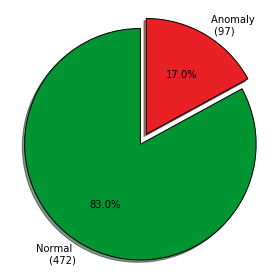

In [17]:
fig, ax = plt.subplots(figsize=(4,4))
plot_pie(ax, anomaly, **plot_kwargs)
fig.tight_layout()
plt.show()

- Visaulize `Principal Component` in pair and see how `feature` in `eigenvector` influence the spred or cluster of data.

In [18]:
# Number of columns.
n_col = 3; cutoff = 0.4

# Combination of Principal Components.
pairs = list(combinations(np.arange(pc_df.shape[1])+1, 2))

# Number of rows --> Calculate from number of pairs and `n_col`
n_row = np.ceil(len(pairs)/n_col).astype(int); n_pairs = len(pairs)

# Define `loc` (x,y) for each `plt.subplot`.
locs = [(r,c) for r in range(n_row) for c in range(n_col)][:n_pairs]

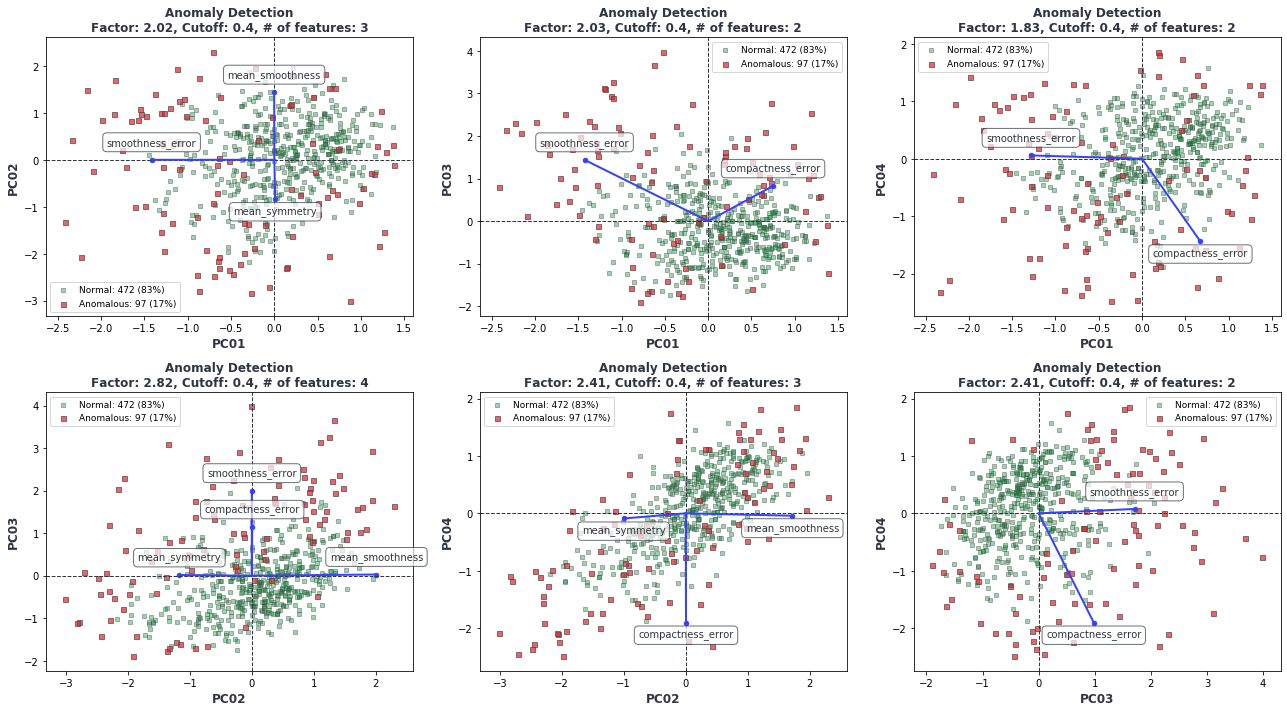

In [19]:
# Create figure and plots.
fig = plt.figure(figsize=(n_col*6, n_row*5))
axes = [plt.subplot2grid((n_row, n_col),loc) for loc in locs]
    
# Plot all combination of PCs.
for (ax,pc) in zip(axes, pairs):
    kw = dict(pc=pc, cutoff=cutoff)
    plot_pcs(ax, anomaly, pc_df, loadings, **kw)
fig.tight_layout()
plt.show()

<font color='#0652DD'> 
Although, using `Principal Component` might yield better result (due to scaling effect, `eigenvalue`), yet it is farily difficult when it comes to explanation. To avoid such confusion, we could try to use normal features instead. </font>

---

- Find the difference of normalized values between `normal` and `anomaly` by features. This helps enable the comparison across features.
- `difference` can be viewed as a distance between two distributions from any nth-percentile of interests (`q1`).
- This returns array of `difference` by features as well as `cutoff` given nth-percentile (`q2`)

In [20]:
difference, cutoff = diff_normalize(X, anomaly, q1=50, q2=60)

- Visualize the `difference` and see how many features make the cutoff. 
- The `scree plot`, that is used to determine the number of factors e.g. `Principal Component`, is also applicable to determine number of features.

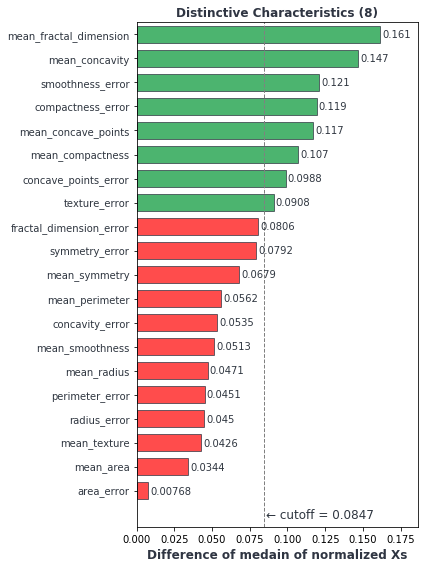

In [21]:
fig, ax = plt.subplots(figsize=(6,8))
features = np.array(list(X))[difference[:,-1].astype(int)]
plot_barh(ax, features, difference[:,0], cutoff)
fig.tight_layout()
plt.show()

<font color='#0652DD'> There are 8 variables that make the cutoff. These variables clearly illustrate the gap between two distributions. </font>

---

### <font color='#e84118' size=4> Decision required </font>
- Select number of features (`variable`).

In [22]:
# To manually define numver of variables.
#n_features = 8; variable = features[:n_features]
# Automatically select variable above cutoff.
variable = features[:(difference[:,0]>=cutoff).sum()]

- Plot `variable` that make distinct difference (distance) between `normal` and `anomaly` distributions. 
- This provides an overview of how `normal` and `anomaly` differ from one another by prominent features.

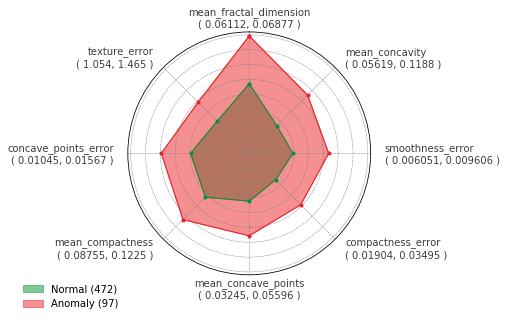

In [23]:
fig = plt.figure(figsize=(7,7))
ax = plt.subplot(polar=True)
plot_radar().fit(ax, X[variable], anomaly, **plot_kwargs)
fig.tight_layout()
plt.show()

<font color='#0652DD'> 
Alternatively, we can compute descriptive statistics (similarly to `pd.DataFrame.describe`) to observe e.g. the central tendency, dispersion and shape of distribution. This enables us to identify which `variable` that clearly separate `anomaly` from `normal`. 
    
For this example, we are using function called `describe_y` to determine any statistical values of our interests. The applicable `aggregating function` inputs are of `numpy` or any function that implements the same interface.
</font>

In [24]:
# Function to use for aggregating the data.
def pct(n): 
    def nan_pct(x): return np.nanpercentile(x, n)
    nan_pct.__name__ = 'pct_{}'.format(n) 
    return nan_pct

def iqr():
    p = lambda x : np.nanpercentile(x, [25,75])
    def nan_iqr(x): return np.diff(p(x))
    nan_iqr.__name__ = 'IQR'
    return nan_iqr

In [25]:
fnc = [pct(n) for n in range(0,101,25)] + [iqr(), np.mean, np.std]
stats = describe_y(X[variable], np.where(anomaly==0,'normal','anomaly'), fnc)
stats.loc[stats.index.get_level_values('feature').isin(variable[:2])]

pct_0     pct_25    pct_50    pct_75  \
feature                flag                                              
mean_fractal_dimension anomaly  0.05025    0.06072   0.06877   0.07398   
                       normal   0.04996  0.0573925  0.061115   0.06488   
mean_concavity         anomaly        0    0.03332    0.1188    0.2135   
                       normal         0  0.0290975   0.05619  0.112625   

                                pct_100        IQR       mean         std  
feature                flag                                                
mean_fractal_dimension anomaly  0.09744    0.01326  0.0686595   0.0101863  
                       normal   0.07976  0.0074875  0.0615929  0.00551682  
mean_concavity         anomaly   0.4268    0.18018   0.137862    0.116501  
                       normal    0.3368  0.0835275  0.0787165    0.065575

<font color='#0652DD'> 
Sometimes establishing a simple rule-based cutoff comes in handy as it provides an easy-to-understand limit, where data that lies beyond this point is identified as `anomaly`, as opposed to model that requires more effort to explain. 

In this example, `optimize_condition` is deployed to optimize the combination of `variable` that maximize `f1-score`. 
    
</font>

In [26]:
criteria = optimize_condition(X[variable].copy(), anomaly.copy(), n_max=1000)

In [27]:
criteria

{'criteria': [['smoothness_error', '≥', 0.01097],
  ['compactness_error', '≥', 0.04674],
  ['mean_compactness', '≥', 0.2106]],
 'confusion_matrix': [441, 24, 31, 73],
 'f1_score': 0.7264}

### The interpretation of results

<font color='#0652DD'>
    
---    
- Data is identified as `anomaly` when it satisfies one of the following criteria:
    - `smoothness_error`  ≥ 0.01097 `or`
    - `compactness_error` ≥ 0.04674 `or`
    - `mean_compactness`  ≥ 0.2106
    
    
- `confusion_matrix` is determined by obtained criteria. Its elements are arranged in the following manner:

|Confusion Matrix  |  N | 
|:----------------:|---:|
|**True Negative** | 441|
|**False Negative**|  21| 
|**False Positive**|  31|
|**True Negative** |  73|

</font>